<a href="https://colab.research.google.com/github/Megancodes2017/Megancodes2017/blob/main/Scouting_Report(PhilsvsOhtani).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_batter, statcast_pitcher, playerid_lookup

In [4]:
pid_df = playerid_lookup('Ohtani', 'Shohei')
print(pid_df[['name_last', 'name_first', 'key_mlbam']])

Gathering player lookup table. This may take a moment.
  name_last name_first  key_mlbam
0    ohtani     shohei     660271


In [5]:
pid = pid_df['key_mlbam'].iloc[0]

In [6]:
# Get Ohtani's pitch data from 2025 season
start_date = '2025-06-16'
end_date = '2025-09-23'
pitches = statcast_pitcher(start_date, end_date, pid)

Gathering Player Data


In [7]:
# Summarize Ohtani's pitch arsenal
ohtani_summary = (
    pitches.groupby('pitch_type')
    .agg(
        usage=('pitch_type', 'count'),
        avg_velo =('release_speed', 'mean'),
        avg_spin=('release_spin_rate', 'mean'),
        whiff_rate=('description', lambda x: x.str.contains('swinging_strike').sum() / x.str.contains('swing|foul|hit_into_play|missed_bunt').sum()),
        avg_xwoba=('estimated_woba_using_speedangle', 'mean')
    )
)

ohtani_summary['usage_pct'] = ohtani_summary['usage'] / ohtani_summary['usage'].sum()
print(ohtani_summary)

            usage   avg_velo     avg_spin  whiff_rate  avg_xwoba  usage_pct
pitch_type                                                                 
CU             66  78.568182  2653.348485    0.550000   0.180308   0.087649
FC             50  93.874000  2531.520000    0.107143   0.493375   0.066401
FF            291  98.423368  2467.140893    0.187919   0.252569   0.386454
FS             35  90.300000  1507.714286    0.300000   0.246167   0.046481
SI             54  96.218519  2143.481481    0.173913   0.395500   0.071713
SL             85  88.115294  2546.976471    0.425926   0.170019   0.112882
ST            172  84.979070  2593.953488    0.373626   0.206450   0.228420


In [8]:
# Get Phillies hitters MLBAM IDs and 2025 splits
phillies_hitters = [
    'Trea Turner', 'Kyle Schwarber', 'Bryce Harper', 'JT Realmuto', 'Nick Castellanos',
    'Alec Bohm', 'Bryson Stott', 'Brandon Marsh', 'Max Kepler', 'Harrison Bader',
    'Edmundo Sosa', 'Otto Kemp', 'Rafael Marchán', 'Weston Wilson'
]

ids = {}
for h in phillies_hitters:
    pid_df = playerid_lookup(h.split()[1], h.split()[0])
    if not pid_df.empty:
        ids[h] = pid_df['key_mlbam'].values[0]
    else:
        print(f"Could not find MLBAM ID for {h}")

print(ids)

Could not find MLBAM ID for JT Realmuto
{'Trea Turner': np.int64(607208), 'Kyle Schwarber': np.int64(656941), 'Bryce Harper': np.int64(547180), 'Nick Castellanos': np.int64(592206), 'Alec Bohm': np.int64(664761), 'Bryson Stott': np.int64(681082), 'Brandon Marsh': np.int64(669016), 'Max Kepler': np.int64(596146), 'Harrison Bader': np.int64(664056), 'Edmundo Sosa': np.int64(624641), 'Otto Kemp': np.int64(805249), 'Rafael Marchán': np.int64(665561), 'Weston Wilson': np.int64(642215)}


In [9]:
# Pull matchup splits vs pitch types
def hitter_splits(hitter_id, start='2025-03-20', end='2025-09-30'):
  df = statcast_batter(start_date, end_date, hitter_id)
  return (
      df.groupby('pitch_type')
      .agg(
          swings=('description', lambda x: sum(x.str.contains('swing'))),
          whiffs=('description', lambda x: sum(x.str.contains('swinging_strike'))),
          total_pitches=('pitch_type', 'size'),
          avg_xwoba=('estimated_woba_using_speedangle', 'mean')
      )
      .assign(whiff_rate=lambda d: d['whiffs']/d['total_pitches'].replace(0,1))
  )

hitter_reports = {h: hitter_splits(ids[h], start='2025-03-20', end='2025-09-30') for h in phillies_hitters if h in ids}

Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data


In [10]:
# Compare Ohtani's pitch effectiveness vs Phillies' hitters
report = {}
for hitter, df in hitter_reports.items():
  merged = df.join(ohtani_summary, how='inner', rsuffix='_ohtani')
  report[hitter] =  merged[['avg_xwoba', 'whiff_rate', 'avg_xwoba_ohtani', 'whiff_rate_ohtani']]

In [15]:
# Generate scouting report
for hitter, df in report.items():
  print(f'\n--- {hitter} ---')
  for pitch in df.index:
    h_xwoba = df.loc[pitch, 'avg_xwoba']
    o_xwoba = df.loc[pitch, 'avg_xwoba_ohtani']
    if h_xwoba > 0.324:
      print(f'{hitter} hits the {pitch} well (xwOBA {h_xwoba:.3f}), risk pitch.')
    elif h_xwoba < 0.300:
      print(f'{hitter} struggles vs {pitch} (xwOBA {h_xwoba:.3f}), good matchup for Ohtani.')


--- Trea Turner ---
Trea Turner struggles vs CU (xwOBA 0.230), good matchup for Ohtani.
Trea Turner hits the FC well (xwOBA 0.372), risk pitch.
Trea Turner hits the FF well (xwOBA 0.336), risk pitch.
Trea Turner struggles vs FS (xwOBA 0.272), good matchup for Ohtani.
Trea Turner hits the SI well (xwOBA 0.349), risk pitch.
Trea Turner hits the SL well (xwOBA 0.378), risk pitch.
Trea Turner struggles vs ST (xwOBA 0.247), good matchup for Ohtani.

--- Kyle Schwarber ---
Kyle Schwarber hits the FC well (xwOBA 0.569), risk pitch.
Kyle Schwarber hits the FF well (xwOBA 0.451), risk pitch.
Kyle Schwarber hits the FS well (xwOBA 0.346), risk pitch.
Kyle Schwarber hits the SI well (xwOBA 0.518), risk pitch.
Kyle Schwarber hits the ST well (xwOBA 0.354), risk pitch.

--- Bryce Harper ---
Bryce Harper hits the CU well (xwOBA 0.331), risk pitch.
Bryce Harper hits the FC well (xwOBA 0.575), risk pitch.
Bryce Harper hits the FF well (xwOBA 0.435), risk pitch.
Bryce Harper struggles vs FS (xwOBA 0.2

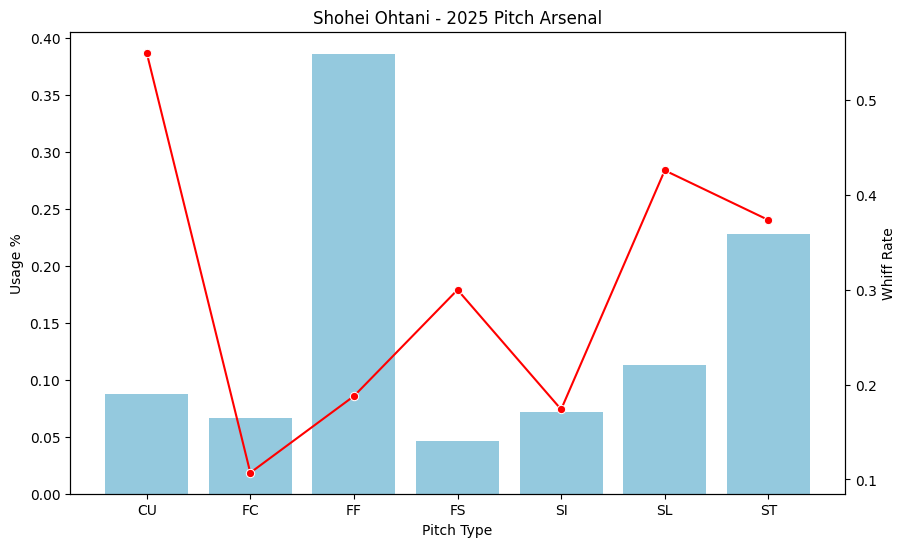

In [16]:
# Ohtani's arsenal chart
# Reset index for plotting
arsenal = ohtani_summary.reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))
sns.barplot(data=arsenal, x='pitch_type', y='usage_pct', ax=ax1, color='skyblue')
ax1.set_ylabel('Usage %')
ax1.set_xlabel('Pitch Type')
ax1.set_title('Shohei Ohtani - 2025 Pitch Arsenal')

# Overlay average whiff rate
ax2 = ax1.twinx()
sns.lineplot(data=arsenal, x='pitch_type', y='whiff_rate', ax=ax2, color='red', marker='o')
ax2.set_ylabel('Whiff Rate')

plt.show()